# Z01.5: Extra Analyses

This notebook contains the extra analyses that supplement the paper for the first Scribal Intent Study (Z01).

## Setup and Utility Functions

In [150]:
# Imports and setup
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
import os

from qlynx.file_utils import load_pkl
from qlynx.stats_utils import *
from qlynx.display_utils import render_html_to_image
from voynichlib.utils import display_voynichese
from qlynx.file_utils import store_pkl, load_pkl


%reload_ext autoreload
%autoreload 2
 

# Set Global Parameters

In [151]:
do_parametric_studies = True
MAX_BAYES = np.exp(10)
MAX_PROPENSITY = 999
THRESHOLDS = {
    'p_value': 0.01,
    'ln_bayes_factor': 5
}
THRESHOLDS['bayes_factor'] = np.exp(THRESHOLDS['ln_bayes_factor'])
reference_cohort = 'MIDDLE'
smooth = None



# Load the Token Cohort Data

In [152]:
file_path = 'voynich_data/outputs/token_cohort_data.pkl'
token_cohort_data = load_pkl(file_path)

cohorts = token_cohort_data['cohorts']
cohorts_with_randoms = token_cohort_data['cohorts_with_randoms']

corpus_by_c = token_cohort_data['corpus_by_c']
pmfs_by_c = token_cohort_data['pmfs_by_c']
token_ws_by_c = token_cohort_data['token_ws_by_c']

glyph_pmfs_by_c = token_cohort_data['glyph_pmfs_by_c']
glyphs_by_c = token_cohort_data['glyphs_by_c']

# Cross-Analysis for Propensity Tokens

In [153]:
file_path = 'voynich_data/outputs/token_propensity_dfs.pkl'
token_propensity_dfs = load_pkl(file_path)
token_propensity_dfs['FIRST']


,glyph_count,N_ref,n_ref,N_x,n_x,p_ref,p_x,p_value,sig_p_value,sig_BF,propensity,bayes,binom_stat_le,binom_stat_gt
token,,,,,,,,,,,,,,
chol,4,3807,180,998,10,0.047281,0.010020,2.965859e-11,True,True,0.2,22026.465795,2.965859e-11,0.0
daiin,5,3807,178,998,42,0.046756,0.042084,2.708710e-01,False,False,0.9,1.287254,2.708710e-01,0.0
chor,4,3807,107,998,7,0.028106,0.007014,1.861640e-06,True,True,0.2,22026.465795,1.861640e-06,0.0
s,1,3807,75,998,4,0.019701,0.004008,1.964432e-05,True,True,0.2,12288.718464,1.964432e-05,0.0
chy,3,3807,72,998,1,0.018913,0.001002,1.072737e-07,True,True,0.1,22026.465795,1.072737e-07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ckheal,6,3807,1,998,0,0.000263,0.000000,7.693701e-01,False,False,0.0,1.299765,7.693701e-01,0.0
ckheor,6,3807,1,998,0,0.000263,0.000000,7.693701e-01,False,False,0.0,1.299765,7.693701e-01,0.0
oral,4,3807,1,998,1,0.000263,0.001002,2.306299e-01,False,False,3.8,1.824425,9.711125e-01,0.0


In [154]:
def make_master_table(criteria):
    def meets_criteria(row):
        return row['sig_p_value'] if criteria == 'p_value' else row['sig_BF'] if criteria == 'bayes' else (row['sig_BF']&row['sig_p_value'])
        
    token_dict = {}
    for cohort, propensity_df in token_propensity_dfs.items():
        for token, row in propensity_df.iterrows():
            if token not in token_dict:
                token_dict[token] = {}
            if cohort not in token_dict:
                token_dict[token][cohort] = {}
            token_dict[token][cohort] = 0
            if meets_criteria(row):
                token_dict[token][cohort] = 1 if row['propensity'] > 1 else -1
            pass
        pass
    pass
    # print(token_dict)
    df = pd.DataFrame(columns = ['token', 'TOP', 'FIRST', 'BEFORE', 'AFTER', 'LAST'])
    for token, pos_dict in token_dict.items():
        row_list = [token]
        count_non_zero = 0
        for col in df.columns[1:]:
            if col in pos_dict:
                row_list.append(pos_dict[col])
                count_non_zero += pos_dict[col] != 0
            else:
                row_list.append(0)
        if count_non_zero > 0:
            df.loc[len(df)] = row_list
        pass
    return df
            
master_df = make_master_table('both')


## Plot the Master Table as Heatmap

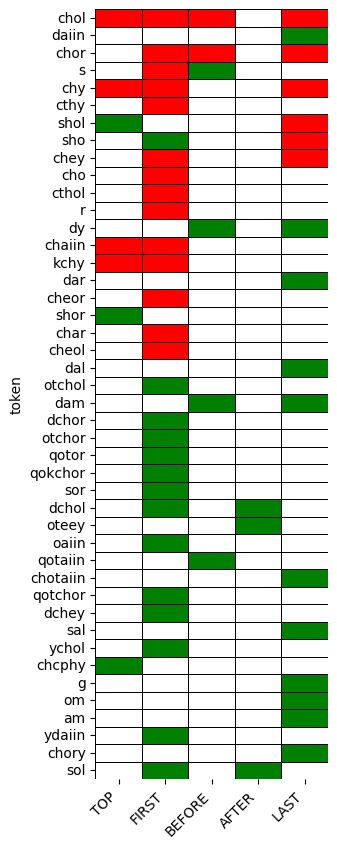

In [155]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_custom_heatmap(df):
    # Set the 'token' column as the index
    df = df.set_index('token')
    
    # Define a custom colormap: red for -1, white for 0, green for 1
    cmap = ListedColormap(['red', 'white', 'green'])
    bounds = [-1, 0, 1, 2]  # Define boundaries for color mapping
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    # Set a larger figure size to accommodate all rows
    plt.figure(figsize=(3, 10))  # You might need to adjust these dimensions based on your specific dataset
    
    # Create a heatmap using seaborn with our custom colormap and normalization
    sns.heatmap(df, annot=False, cmap=cmap, norm=norm, cbar=False, square=False,
                linewidths=0.5, linecolor='black')
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha="right")  # Rotate labels and align right for better readability
    
    plt.show()



plot_custom_heatmap(master_df)

## Make HTML Table of Master Heatmap

In [ ]:
def html_table_to_file(df, file_name, width, height):
    # Define the color mapping based on value ranges
    def color_for_value(value):
        if value == -1:
            return 'red'
        elif value == 0:
            return 'white'
        elif value == 1:
            return 'green'
        else:
            return 'white'  # Default color

        # Determine the max width needed based on the longest column header name
    # Assuming approximately 1em per character for default font settings
    max_header_length = max(len(str(col)) for col in df.columns)
    column_width = max_header_length -1.5  # Adding some extra space for padding

    # Start the HTML document
    html = '<!DOCTYPE html>\n<html>\n<head>\n'
    html += f'<style>table, th, td {{border: 1px solid black; border-collapse: collapse;}} th, td {{padding: 0px; text-align: center;}} th:not(:first-child), td:not(:first-child) {{min-width: {column_width}em; max-width: {column_width}em;}}</style>\n'
    
    html += """<style> 
        .legend-item {
            display: flex;
            align-items: center;
            margin-bottom: 5px;
        }

        .legend-color {
            width: 20px;
            height: 20px;
            margin-right: 10px;
        }

        .legend-label {
            font-size: 16px;
        }
    </style>"""
    
    html += '</head>\n<body>\n<h1>High Propensity Tokens by Position</h1>'

    html += """    
    <div class='legend'>
        <div class='legend-item'>
            <div class='legend-color' style='background-color: green;'></div>
            <div class='legend-label'>Affinitive Propensity</div>
        </div>
        <div class='legend-item'>
            <div class='legend-color' style='background-color: red;'></div>
            <div class='legend-label'>Aversive Propensity</div>
        </div>
    </div>
   """
    
    
    
    # Start the HTML table, including headers at the top
    html += '<table><tr><th></th>'
    for col in df.columns:
        html += f'<th>{col}</th>'
    html += '</tr>'
    
    # Populate the table rows
    for index, row in df.iterrows():
        voynichese_value = display_voynichese(text=index, render=False)
        html += f'<tr><th>{voynichese_value}</th>'
        for col in df.columns:
            color = color_for_value(row[col])
            html += f'<td style="background-color:{color}">&nbsp;</td>'
        html += '</tr>'
    
    # Add headers at the bottom
    html += '<tr><th></th>'
    for col in df.columns:
        html += f'<th>{col}</th>'
    html += '</tr></table>\n'
    
    # End the HTML document
    html += '</body>\n</html>'
    
    if file_name:
        current_dir = os.getcwd()
        print(f"current_dir = {current_dir}")
        html_filename = file_name + '.html'
        absolute_html_file_path = os.path.join(current_dir, html_filename)
        png_filename = file_name + '.png'
        absolute_png_file_path = os.path.join(current_dir, png_filename)
        with open(html_filename, 'w') as file:
            file.write(html)
            print(f"Wrote {html_filename}")
        print(f"absolute_html_file_path = {absolute_html_file_path}")
        render_html_to_image(absolute_html_file_path, absolute_png_file_path, width=width, height=height+129, crop=False)

# Convert the DataFrame to an HTML file
file_name= 'voynich_data/outputs/CUTOFF_T_Propensity_Token'
html_table_to_file(master_df.set_index('token'), file_name, width=630, height=4000)
print(f"HTML table written to {file_name}")


current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote voynich_data/outputs/CUTOFF_T_Propensity_Token.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/voynich_data/outputs/CUTOFF_T_Propensity_Token.html


## Split the Master Propensity Table for Easier Presentation

In [ ]:
top_length = int(len(df)/2)
bottom_length = len(df) - top_length
df1 = df[:top_length]
df2 = df[-bottom_length:]


In [ ]:
print("Master Propensity Table, Part 1")
df1.head(top_length)


In [64]:
print("Master Propensity Table, Part 2")
df2.head(bottom_length)


Master Propensity Table, Part 2


,token,TOP,FIRST,BEFORE,AFTER,LAST
22,dam,0,0,1,0,1
23,dchor,0,1,0,0,0
24,otchor,0,1,0,0,0
25,qotor,0,1,0,0,0
26,qokchor,0,1,0,0,0
27,sor,0,1,0,0,0
28,dchol,0,1,0,1,0
29,oteey,0,0,0,1,0
30,oaiin,0,1,0,0,0
31,qotaiin,0,0,1,0,0


# Append Data from Bunn Research to Master Table

Bunn has listed tokens by their appearance in certain positions. These, however, are only based on appearance frequencies (prevelance).  It is helpful to compare them to the results from the propensity analysis. 
The Bunn data (from:  ) is as follows:
 * Words often in First Position – dai, daiin, dair, sai, saiin, sar, sol
 * Words often in Last Position – am, dy, oky, oly, qoky
 * Words never in First Position – ai, aiin, air, al, am, chcthy, chdy, checkhy, cheedy, cheky, cheody, chody, chy, dy, kai, kedy, keedy, okal, okedy, oky, oly, opchedy, otai, otal, otar, oty, raiin, shckhy
 * Words never in Last Position – ai, cheo, dai, kai, kaiin, okai, otai, qokai, qokain, qotai, sai, shckhy, sheedy
 * Words never in First or Last Position – ai, kai, otai, shckhy

  (Bunn's data also looks at a larger corpus than the current study.)

In [65]:
bunn_dict = {}
bunn_dict['FIRST_OFTEN'] = ['dai', 'daiin', 'dair', 'sai', 'saiin', 'sar', 'sol']
bunn_dict['FIRST_NEVER'] = ['ai', 'aiin', 'air', 'al', 'am', 'chcthy', 'chdy', 'checkhy', 'cheedy', 'cheky', 'cheody', 'chody', 'chy', 
                            'dy', 'kai', 'kedy', 'keedy', 'okal', 'okedy', 'oky', 'oly', 'opchedy,', 'otai', 'otal', 'otar', 'oty', 
                            'raiin', 'shckhy']
bunn_dict['LAST_OFTEN'] = ['am', 'dy', 'oky', 'oly', 'qoky']
bunn_dict['LAST_NEVER'] = ['ai', 'cheo', 'dai', 'kai', 'kaiin', 'okai', 'otai', 'qokai', 'qokain', 'qotai', 'sai', 'shckhy', 'sheedy']


In [50]:
# file_path = 'voynich_data/outputs/token_propensity_dfs.pkl'
# token_propensity_dfs = load_pkl(file_path)


In [149]:
def make_bunn_comparison_dataframe(cohort, tilt): 
    num_tokens_in_target = pmfs_by_c[cohort].total_count
    xdf = token_propensity_dfs[cohort]
    xdf_first_affinitive = xdf[(xdf['sig_p_value'] > 0) & (xdf['sig_BF'] > 0) & (xdf['propensity'] >= 1)]
    xdf_first_aversive = xdf[(xdf['sig_p_value'] > 0) & (xdf['sig_BF'] > 0) & (xdf['propensity'] < 1)]
    if tilt ==1:
        study_set = set(xdf_first_affinitive.index)
        bunn_set = set(bunn_dict[f"{cohort}_OFTEN"])
        all_set = {*study_set, *bunn_set}
        tilt_label = 'POSITIVE'
    elif tilt ==-1:
        study_set = set(xdf_first_aversive.index)
        bunn_set = set(bunn_dict[f"{cohort}_NEVER"])
        all_set = {*study_set, *bunn_set}
        tilt_label = 'NEGATIVE'
    # print(f"{cohort} {tilt_label}")
    both = []
    missing_in_bunn = []
    not_in_study = []
    
    for tok in sorted(all_set):
        if tok in study_set and tok not in bunn_set:
            color = 'black'
            missing_in_bunn.append(tok)
        elif tok not in study_set and tok in bunn_set:
            color = 'grey'
            not_in_study.append(tok)
        elif  tok in study_set and tok in bunn_set:
            color = 'red'
            both.append(tok)
    df = pd.DataFrame(columns = ['token', 'expected', 'observed', 'propensity', 'p_value', 'bayes', 'comment_code', 'n_x', 'p_ref', 'color'])
            
    def get_row_data(tok):
        row = xdf.loc[tok]
        p_value = row['p_value']
        bayes = row['bayes']
        prob_ref = row['p_ref']                
        observed_count = int(row['n_x'])
        expected_count =  int(np.round(prob_ref * num_tokens_in_target))
        propensity = row['propensity']
        p_ref = row['p_ref']
        n_x = row['n_x']
        if row['sig_p_value'] & row['sig_BF'] and row['propensity']>=1.:
            color = 'green'
        elif row['sig_p_value'] & row['sig_BF'] and row['propensity']<1.:
            color = 'red'
        else:
            color = 'grey'
            
        return (expected_count, observed_count, propensity, p_value, bayes, n_x, p_ref, color )
        
    for tok in sorted(both):
        comment_code = 'FOUND'
        expected_count, observed_count, propensity, p_value, bayes,  n_x, p_ref, color = get_row_data(tok)
        df.loc[len(df)] = [tok,  expected_count, observed_count, propensity, p_value, bayes, comment_code,  n_x, p_ref, color]

    for tok in sorted(missing_in_bunn):
        comment_code = 'MISSED'
        expected_count, observed_count, propensity, p_value, bayes,  n_x, p_ref, color = get_row_data(tok)
        df.loc[len(df)] = [tok,  expected_count, observed_count, propensity, p_value, bayes, comment_code,  n_x, p_ref, color]
        
    for tok in sorted(not_in_study):
        if tok in xdf.index:
            comment_code = 'INSIGNIFICANT'
            expected_count, observed_count, propensity, p_value, bayes,  n_x, p_ref, color = get_row_data(tok)
        else:
            comment_code = 'NOT IN CORPUS'
            p_value =0.
            bayes = 0.
            expected_count = 0
            observed_count = 0
            propensity = 0.
            p_ref = 0.
        df.loc[len(df)] = [tok,  expected_count, observed_count, propensity, p_value, bayes, comment_code,  n_x, p_ref, color]
    return df

bunn_df = make_bunn_comparison_dataframe('FIRST', -1)
bunn_df.head(50)

,token,expected,observed,propensity,p_value,bayes,comment_code,n_x,p_ref,color
0,chy,19,1,0.1,1.072737e-07,22026.465795,FOUND,1,0.018913,red
1,chaiin,7,0,0.0,1.070910e-03,933.785343,MISSED,0,0.006830,red
2,char,6,0,0.0,3.076387e-03,325.056603,MISSED,0,0.005779,red
3,cheol,6,0,0.0,3.076387e-03,325.056603,MISSED,0,0.005779,red
4,cheor,6,0,0.0,2.363276e-03,423.141466,MISSED,0,0.006042,red
5,chey,12,0,0.0,5.382892e-06,22026.465795,MISSED,0,0.012083,red
6,cho,10,1,0.1,4.963764e-04,815.194158,MISSED,1,0.009982,red
7,chol,47,10,0.2,2.965859e-11,22026.465795,MISSED,10,0.047281,red
8,chor,28,7,0.2,1.861640e-06,22026.465795,MISSED,7,0.028106,red
9,cthol,9,1,0.1,8.021052e-04,507.035519,MISSED,1,0.009456,red


## Make HTML Table of Bunn Comparison

In [147]:
cohort_title_dict = {
'ALL':'All in Corpus',
'MIDDLE':'Middle Positions',
'TOP':'Top Lines of Paragraphs',
'FIRST': 'First Position on a Line',
'SECOND': 'Second Position on a Line',
'THIRD': 'Third Position on a Line',
'FOURTH': 'Fourth Position on a Line',
'BEFORE': 'Immediately Before a Drawing',
'AFTER':'Immediately After a Drawing',
'LAST': 'Last Position on a Line',
'RAND 1':'Random Tokens Cohort',
'RAND 2':'Random Tokens Cohort', 
'RAND 3':'Random Tokens Cohort',
'RAND 4':'Random Tokens Cohort',
'RAND 5':'Random Tokens Cohort',
'RAND 6':'Random Tokens Cohort',
}
def display_bunn_comparison_summary(cohort, tilt, file_name: str = None, width:int=None, height:int=None):
    df = make_bunn_comparison_dataframe(cohort, tilt)
    comment_dict = {'FOUND': 'Recognized',
                    'MISSED': 'Missed',
                    'INSIGNIFICANT': 'Not Significant',
                    'NOT IN CORPUS': 'N/A'}
    
    table_title = f"Positional Tendency Tokens<br>{cohort_title_dict[cohort]}"
    num_tokens_in_target = pmfs_by_c[cohort].total_count
    num_tokens_in_ref = pmfs_by_c[reference_cohort].total_count
    
    component_text = 'Tokens'
    pass

    
    html_top = """
<html>
<head>
    <style>
        h3 {
            margin-left: auto;
            margin-right: auto;
        }
        table {
            border: 3px solid black;
            border-collapse: collapse;
            margin-left: auto;
            margin-right: auto;
        }

        th, td {
            border: 1px solid black;
            text-align: center;
        }

       .header-row {
            background-color: #7AA4F8;
        }     
        table td, table th {
            padding-left: 5px;
            padding-right: 5px;
        }
        
        tbody tr:nth-child(even) {
            background-color: #FEEFC2; /*#FFFFD9; light beige for odd rows */
        }

        tbody tr:nth-child(odd) {
            background-color: white; /* white for even rows */
        }
    </style>
</head>
<body>"""
    html_bottom = """
</body>
</html>"""
    html = ''
        # <th class='header-row' colspan=1 rowspan=2 style='text-align: center;'>Tilt</th>
    html_table_top = """
<table style='width:600px'>
    <tr>
        <th class='header-row' colspan=2 style='text-align: center;'>Token</th>
        <th class='header-row' colspan=2 style='text-align: center;'>Counts</th>
        <th class='header-row' colspan=3 style='text-align: center;'>Stats</th>
        <th class='header-row' rowspan=2 colspan=3 style='text-align: center;'>Prevalence Approach</th>
    </tr>
    <tr>
        <th class='header-row' >Voynichese</th>
        <th class='header-row' >Eva-</th>
        <th class='header-row' >expected</th>
        <th class='header-row' >observed</th>
        <th class='header-row' >Propensity</th>
        <th class='header-row' ><i>p</i>-value</th>
        <th class='header-row' ><i>log(B)</i></th>
    </tr>"""    
    html_1 = html_table_top
    
    # color = 'black' 
    # Fill the table rows
    i=-1
    for index, row in df.iterrows(): 
        i += 1
        propensity = row['propensity']
        # ln_propensity = np.log(propensity)
        # if propensity < 1:
        #     continue
        token = row['token']
        color = row['color']
        voynichese_value = display_voynichese(text=token, color=color, render=False)
        if color == 'grey':
            token = f"<del>{token}</del>"
        print(voynichese_value)

        prob_ref= row['p_ref']
        p_value = row['p_value']
        # prob_x = row['p_x']
        # N_x = row['N_x']
        comment = comment_dict[row['comment_code']]
        
        observed_count = int(row['n_x'])
        # print(f"prob_ref={prob_ref}, num_tokens_in_target={num_tokens_in_target}")
        expected_count =  int(np.round(prob_ref * num_tokens_in_target))
        bayes = row['bayes']
        bayes = f"{np.log(bayes):.1f}" if bayes > 0 else '0'
        if bayes=='10.0':
            bayes = '>10'
            


        html_1 += f"""            
    <td>{voynichese_value}</td>
    <td>{token}</td>
    <td>{expected_count}</td>
    <td>{observed_count}</td>
    <td>{propensity:.1f}</td>
    <td>{p_value:.6f}</td>
    <td>{bayes}</td>
    <td>{comment}</td>
</tr>"""
            

    html_1 += """
</table>"""
    html += html_1


    # Display the HTML table
    display(HTML(html))
    if file_name:
        current_dir = os.getcwd()
        print(f"current_dir = {current_dir}")
        html_filename = file_name + '.html'
        absolute_html_file_path = os.path.join(current_dir, html_filename)
        png_filename = file_name + '.png'
        absolute_png_file_path = os.path.join(current_dir, png_filename)
        with open(html_filename, 'w') as file:
            file.write(html_top + html + html_bottom)
            print(f"Wrote {html_filename}")
        print(f"absolute_html_file_path = {absolute_html_file_path}")
        render_html_to_image(absolute_html_file_path, absolute_png_file_path, width=width, height=height+129, crop=True)
        

In [148]:
display_bunn_comparison_summary('FIRST', -1, file_name='JUNK', width=630, height=500)

<span style="color:red; font-family:'EVA Hand 1'; font-size:100%;">chy</span><br>
<span style="color:red; font-family:'EVA Hand 1'; font-size:100%;">chaiin</span><br>
<span style="color:red; font-family:'EVA Hand 1'; font-size:100%;">char</span><br>
<span style="color:red; font-family:'EVA Hand 1'; font-size:100%;">cheol</span><br>
<span style="color:red; font-family:'EVA Hand 1'; font-size:100%;">cheor</span><br>
<span style="color:red; font-family:'EVA Hand 1'; font-size:100%;">chey</span><br>
<span style="color:red; font-family:'EVA Hand 1'; font-size:100%;">cho</span><br>
<span style="color:red; font-family:'EVA Hand 1'; font-size:100%;">chol</span><br>
<span style="color:red; font-family:'EVA Hand 1'; font-size:100%;">chor</span><br>
<span style="color:red; font-family:'EVA Hand 1'; font-size:100%;">cthol</span><br>
<span style="color:red; font-family:'EVA Hand 1'; font-size:100%;">cthy</span><br>
<span style="color:red; font-family:'EVA Hand 1'; font-size:100%;">kchy</span><br>
<

current_dir = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24
Wrote JUNK.html
absolute_html_file_path = /Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/JUNK.html
Visible Content Height: 490
Total Document Width: 615
Total Document Height: 1478
Cropped image saved as '/Users/andrew/GITHUB/Z01-SOM_Histocrypt_24/JUNK.png'


## Glyph Propensities

In [1]:
def compile_glyph_propensity_df(target_cohort, reference_cohort, p_value_threshold, bayes_threshold):
    top_token_length_dict = get_top_vocabulary_tokens_lengths_dict(reference_cohort)
    df = pd.DataFrame(columns = ['glyph',  'N_ref', 'n_ref', 'N_x', 'n_x', 'p_ref', 'p_x',  'p_value', 'sig_p_value', 'sig_BF', 'propensity', 'bayes', 'binom_stat_le', 'binom_stat_gt'])
    glyphs = set(glyphs_by_c['ALL'])
    
    for glyph in glyphs:
        pmf_ref = glyph_pmfs_by_c[reference_cohort]
        N_ref = pmf_ref.total_count
        n_ref = pmf_ref.count(glyph) if N_ref > 0 else 0
        p_ref = pmf_ref.prob(glyph, smooth=smooth)
        if p_ref == 0:
            continue

        pmf_x = glyph_pmfs_by_c[target_cohort]                        
        N_x = pmf_x.total_count
        n_x = pmf_x.count(glyph)  if N_x > 0 else 0
        p_x = pmf_x.prob(glyph, smooth=smooth)
        
        p_value = calculate_binomial_probability(n_x, N_x, p_ref)

        if n_x == 0:
            bayes_factor = 1/MAX_BAYES
        else:
            bayes_factor = bayes_factor_binomial(n_x, N_x, p_x, p_ref)
            bayes_factor = min(MAX_BAYES, bayes_factor)
        bayes_factor = int(bayes_factor)
        binom_stat_le =  binom.cdf(n_x, N_x, p_ref)        
        binom_stat_gt =  binom.cdf(n_x, N_x, 1. -p_ref)        

        if p_x ==  0.:
            propensity = -MAX_PROPENSITY
        else:
            propensity = p_x/p_ref  if p_ref > 0 else MAX_PROPENSITY
        pass        
            
        verdict_p_value = p_value <= p_value_threshold
        verdict_bayes_factor = bayes_factor >= bayes_threshold

        df.loc[len(df)] = [glyph,
                           N_ref,
                           n_ref,
                           N_x,
                           n_x,
                           p_ref,
                           p_x,
                           p_value,
                           verdict_p_value,
                           verdict_bayes_factor,
                           np.round(propensity,1),
                           bayes_factor,
                          binom_stat_le,
                          binom_stat_gt]
        pass
    df.set_index('glyph', inplace=True)
    pass
    return df